<a href="https://colab.research.google.com/github/EvertonTrentoJR/FittingEIS2orderTF/blob/main/coef_minimization_EIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Second-Order Transfer Function Approach for Fitting Electrical Impedance Spectroscopy Data

**Author:  Everton Trento Jr**

This code implements a curve-fitting algorithm for electrical impedance spectroscopy (EIS) using second-order transfer-function modeling. Two approaches are implemented. The first uses synthetic data as input to the fitting algorithm and can be configured for first- or second-order models. The second uses experimental data acquired with a Keysight E4980A LCR impedance analyzer and a liquid test fixture that measures water as it freezes into ice at −5 °C.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
import os
import pandas as pd
from google.colab import drive

# **Input Synthetic Data**

In [31]:
class InputDataSynthetic:
    def __init__(self, syntP=None, freq=None ):
        self.freq = freq
        self.w = 2 * np.pi * self.freq
        self.jw = 1j * self.w
        self.syntP = syntP
        self.generateSyntheticTF()
        self.plot_input_data()
        self.magphase_complex = {}

    def get_data(self):
      return self.mag_data, self.phase_data

    def genera1TF(self, params):
        # First-order: H(jw) = (a0 + a1*jw) / (b0 + b1*jw)
        a0, a1, b0, b1 = params
        jw = self.jw
        return (a0 + a1 * jw) / (b0 + b1 * jw)

    def genera2TF(self, params):
        # Second-order: H(jw) = (a0 + a1*jw + a2*jw**2) / (b0 + b1*jw + b2*jw**2)
        a0, a1, a2, b0, b1, b2 = params
        jw = self.jw
        return (a0 + a1 * jw + a2 * jw ** 2) / (b0 + b1 * jw + b2 * jw ** 2)

    def generateSyntheticTF(self):
        if len(self.syntP) == 6:
            self.true_params = self.syntP
            self.H_true = self.genera2TF(self.true_params)
        elif len(self.syntP) == 4:
            self.true_params = self.syntP
            self.H_true = self.genera1TF(self.true_params)
        else:
            raise ValueError("syntheticParams must have 4 (1st order) or 6 (2nd order) values")

        # self.mag_true = 20 * np.log10(np.abs(self.H_true))
        self.phase_true = np.angle(self.H_true)

        # self.mag_data = self.mag_true
        self.mag_data = np.abs(self.H_true)
        self.phase_data = self.phase_true

    def experimental(self):
        from google.colab import drive
        drive.mount('/content/drive')

    def plot_input_data(self):
        plt.figure(figsize=(12, 5))

        # Plot magnitude
        plt.subplot(1, 2, 1)
        plt.semilogx(self.freq, self.mag_data, label='Measured Data', color='blue')
        plt.title('Magnitude Response (Input Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('|H(jω)| [dB]')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        # Plot phase
        plt.subplot(1, 2, 2)
        plt.semilogx(self.freq, self.phase_data, label='Measured Data', color='green')
        plt.title('Phase Response (Input Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('∠H(jω) [deg]')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def magphase_to_complex(self, deg=True):
        if deg:
          self.phase_data = np.deg2rad(self.phase_data)
        self.magphase_complex = self.mag_data * np.exp(1j * self.phase_data)
        return self.magphase_complex


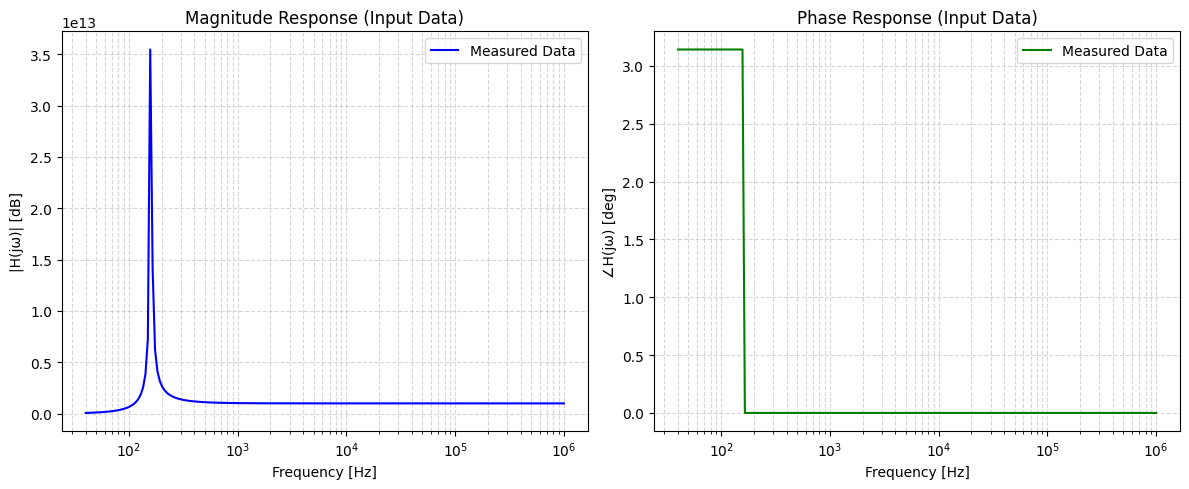

In [32]:
freq = np.logspace(np.log10(40), 6, 201)  # 40 Hz to 1 MHz in 201 points
# syntheticParams = [1.0, 0.0, 1e-6, 10.0] # a0, a1, b0, b1 for first order TF
syntheticParams  = [1.0, 10.0, 1e6, 1.0, 0.0, 1e-6]  # a0, a1, a2, b0, b1, b2 for second order TF
order = 2

input_data_synt = InputDataSynthetic(syntP=syntheticParams, freq=freq)

mag_data, phase_data = input_data_synt.get_data()

magphase_complex = input_data_synt.magphase_to_complex(deg=True)

# **Input Experimental Data**

In [4]:
class InputDataExperimental:
  def __init__(self, freq=None ):
      self.freq = freq
      self.w = 2 * np.pi * self.freq
      self.jw = 1j * self.w

      self.results = {}
      self.mag_file = {}
      self.mag_data = {}
      self.phase_data = {}
      self.magphase_complex = {}

      self.plot_input_data()

  def experimental(self):
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/'
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

    for file in csv_files:
      full_path = os.path.join(path, file)
      print(f"Reading.... {full_path}")
      df = pd.read_csv(full_path)
      df = df.iloc[:, 1:]
      self.results[file] = df.mean(numeric_only=True)

    self.summary = pd.DataFrame(self.results)
    return self.summary


  def get_data(self):
    self.mag_data.clear()
    self.phase_data.clear()

    for file, vals in self.results.items():
        # ensure even length: pairs (Z, TD) for each frequency
        if vals.size % 2 != 0:
            vals = vals[:-1]
        self.mag_file[file] = vals[0::2]  # Z
        self.phase_data[file] = vals[1::2]  # TD (deg)
        self.mag_data[file] = 20 * np.log10(np.abs(self.mag_file[file])) # Z in dB
    return self.mag_data, self.phase_data

  def plot_input_data(self):

    files = sorted(set(self.mag_data) & set(self.phase_data))

    for file in files:
      print("Plot experimental data:  ")

      plt.figure(figsize=(12, 5))
      plt.suptitle(f'Experimental Data: {file}')

      # Magnitude
      plt.subplot(1, 2, 1)
      plt.semilogx(self.freq, self.mag_data[file], label=f'{file}', marker='o')
      plt.title('Magnitude Response (Input Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('|H(jω)| [dB]')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      # Phase
      plt.subplot(1, 2, 2)
      plt.semilogx(self.freq, self.phase_data[file], label=f'{file}', marker='x')
      plt.title('Phase Response (Input Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('∠H(jω) [deg]')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      plt.tight_layout()
      plt.show()

  # def magphase_to_complex(self, deg=True):
  #   if deg:
  #     self.phase_data = np.deg2rad(self.phase_data)
  #   self.magphase_complex = self.mag_data * np.exp(1j * self.phase_data)
  #   return self.magphase_complex

Mounted at /content/drive
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/W.csv
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/C0.csv
Reading.... /content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/ICE.csv
Plot experimental data:  


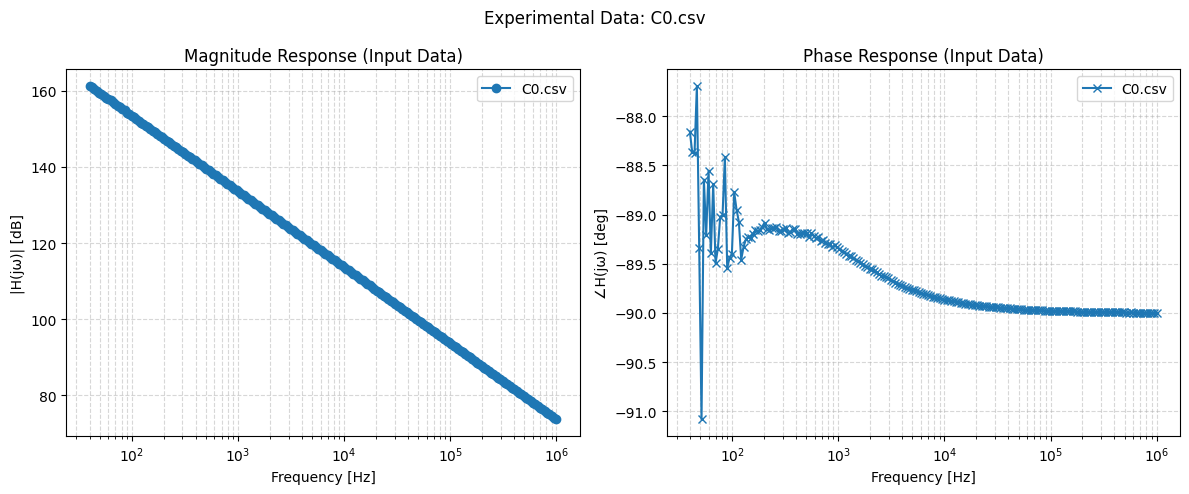

Plot experimental data:  


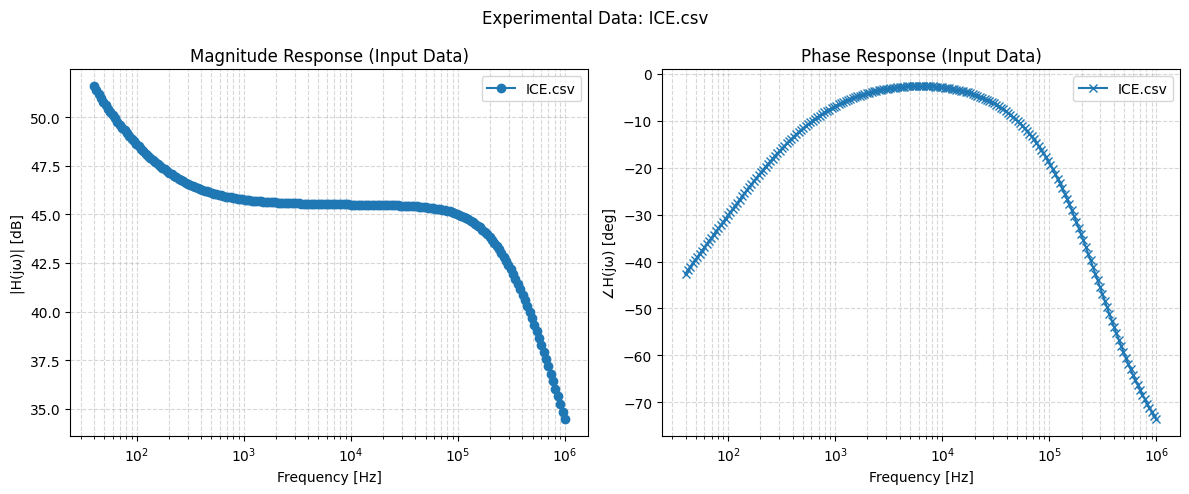

Plot experimental data:  


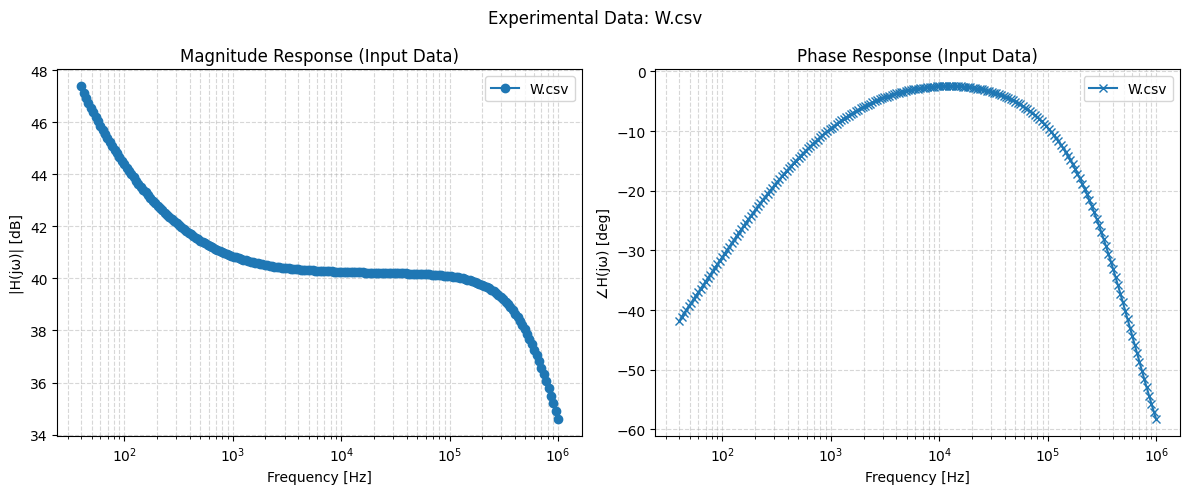

In [5]:
freq = np.logspace(np.log10(40), 6, 201)  # 40 Hz to 1 MHz in 201 points

input_exp = InputDataExperimental(freq=freq)

summary = input_exp.experimental()

mag_exp, phase_exp = input_exp.get_data()

input_exp.plot_input_data()

# input_exp.magphase_to_complex(deg=True)

# **Define Loss Function**

In [36]:
def loss_function(params, freq, mag_data, phase_data, order=2):
    w = 2 * np.pi * freq
    jw = 1j * w

    if order == 2:
        b0, b1, b2, a0, a1, a2 = params
        num = a0 + a1 * jw + a2 * jw**2
        den = b0 + b1 * jw + b2 * jw**2
        H = num / den
    else:
        a0, a1, b0, b1 = params
        H = (a0 + a1 * jw) / (b0 + b1 * jw)

    # Estimated response
    mag_est = 20 * np.log10(np.abs(H))
    phase_est = np.angle(H, deg=True)

    # Compute error
    mag_error = mag_data - mag_est
    phase_error = phase_data - phase_est

    # Return the sum of squared errors as a scalar
    return np.sum(mag_error**2 + phase_error**2)

def loss_function_complex(params, freq, magphase_complex, order=2):

    w = 2 * np.pi * np.asarray(freq, dtype=float)
    jw = 1j * w

    if order == 2:
        b0, b1, b2, a0, a1, a2 = params
        num = a0 + a1 * jw + a2 * (jw**2)
        den = b0 + b1 * jw + b2 * (jw**2)
        H = num / den
    else:
        a0, a1, b0, b1 = params
        H = (a0 + a1 * jw) / (b0 + b1 * jw)

    # Compare complex values in linear units
    diff = H - np.asarray(magphase_complex)

    # Sum of squared error as a scalar
    return float(np.vdot(diff, diff).real)

def coef2spectrum(fitparams,freq,order=2):
  # applies the fit coeficients and calculate the fitted phase and magnitude
  w = 2 * np.pi * freq
  jw = 1j * w

  if order == 2:
        b0, b1, b2, a0, a1, a2 = fitparams
        num = a0 + a1 * jw + a2 * jw**2
        den = b0 + b1 * jw + b2 * jw**2
        H_fit = num / den
  else:
      a0, a1, b0, b1 = fitparams
      H_fit = (a0 + a1 * jw) / (b0 + b1 * jw)

  mag_fit = 20 * np.log10(np.abs(H_fit))
  phase_fit = np.angle(H_fit, deg=True)

  return mag_fit, phase_fit

def pltFit(freq, mag_data, mag_fit, phase_data, phase_fit):

  mag_data = 20 * np.log10(np.abs(mag_data))
  mag_fit = 20 * np.log10(np.abs(mag_fit))
  # plot Magnitude and Phase for fitted and raw data
  plt.figure(figsize=(12, 5))

  # Plot magnitude
  plt.subplot(1, 2, 1)
  plt.semilogx(freq, mag_data, label='Measured Data', color='blue')
  plt.semilogx(freq, mag_fit, label='Measured Data', color='red',linestyle=':')
  plt.title('Magnitude Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('|H(jω)| [dB]')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  # Plot phase
  plt.subplot(1, 2, 2)
  plt.semilogx(freq, phase_data, label='Measured Data', color='green')
  plt.semilogx(freq, phase_fit, label='Measured Data', color='red',linestyle=':')
  plt.title('Phase Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('∠H(jω) [deg]')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  plt.tight_layout()
  plt.show()

# **MINIMIZE METHOD**

In [37]:
initial_guess = [1.0, 10.0, 1e6, 1.0, 0.0, 1e-6]   # a0, a1, a2, b0, b1, b2 for second order TF
# initial_guess = [1.0, 1.0, 1.0, 1.0]            # a0, a1, b0, b1 for second order TF

Synthetic data

Optimization terminated successfully.
         Current function value: 1804882366033874454841393152.000000
         Iterations: 30
         Function evaluations: 239
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.8048823660338745e+27
             x: [ 1.000e+00  1.000e+01  1.000e+06  1.000e+00  0.000e+00
                  1.000e-06]
           nit: 30
          nfev: 239
 final_simplex: (array([[ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       ...,
                       [ 1.000e+00,  1.000e+01, ...,  4.657e-13,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06]]), array([ 1.805e+27,  1.805e+27,  1.805e+27,  1.805e+27,
                        1.805e+27,  1.805e+27,  1.805e+27]))
Error P

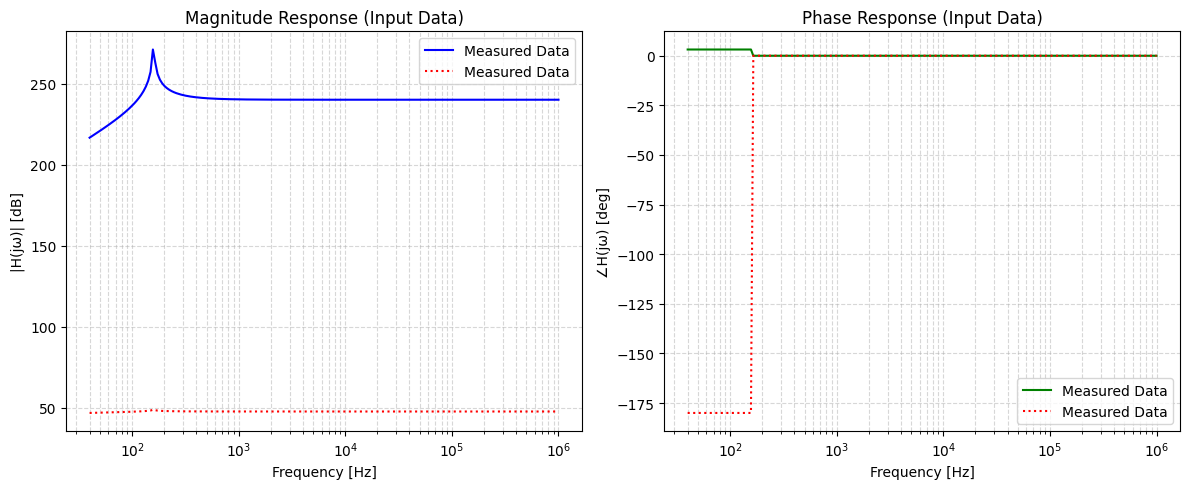

In [38]:
# result_synt = minimize(
#     loss_function,
#     initial_guess,
#     args=(freq, mag_data, phase_data, order),
#     method='Nelder-Mead',
#     options={'maxiter': 10000, 'disp': True})

result_synt = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex, order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})


print(result_synt)
optimized_params_synt = result_synt.x
Error_params = optimized_params_synt - syntheticParams
print('Error Parameters:', Error_params)

mag_fit_synt, phase_fit_synt = coef2spectrum(optimized_params_synt,freq,order=order)
pltFit(freq, mag_data, mag_fit_synt, phase_data, phase_fit_synt)

Experimental data

**C0**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 239
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0
             x: [ 1.000e+00  1.000e+01  1.000e+06  1.000e+00  0.000e+00
                  1.000e-06]
           nit: 30
          nfev: 239
 final_simplex: (array([[ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       ...,
                       [ 1.000e+00,  1.000e+01, ...,  4.657e-13,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06]]), array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
                        0.000e+00,  0.000e+00,  0.000e+00]))


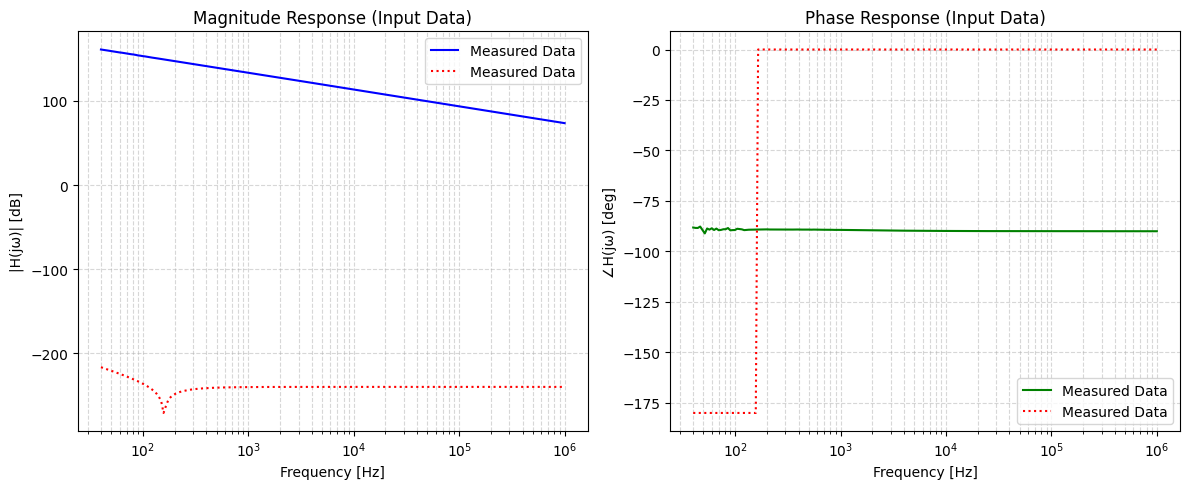

In [9]:
result_exp_C0 = minimize(
    loss_function,
    initial_guess,
    args=(freq, mag_exp['C0.csv'], phase_exp['C0.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_C0)
optimized_params_exp_C0 = result_exp_C0.x

mag_fit_exp_C0, phase_fit_exp_C0 = coef2spectrum(optimized_params_exp_C0,freq,order=order)
pltFit(freq, mag_exp['C0.csv'], mag_fit_exp_C0, phase_exp['C0.csv'], phase_fit_exp_C0)

**WATER**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 239
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0
             x: [ 1.000e+00  1.000e+01  1.000e+06  1.000e+00  0.000e+00
                  1.000e-06]
           nit: 30
          nfev: 239
 final_simplex: (array([[ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       ...,
                       [ 1.000e+00,  1.000e+01, ...,  4.657e-13,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06]]), array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
                        0.000e+00,  0.000e+00,  0.000e+00]))


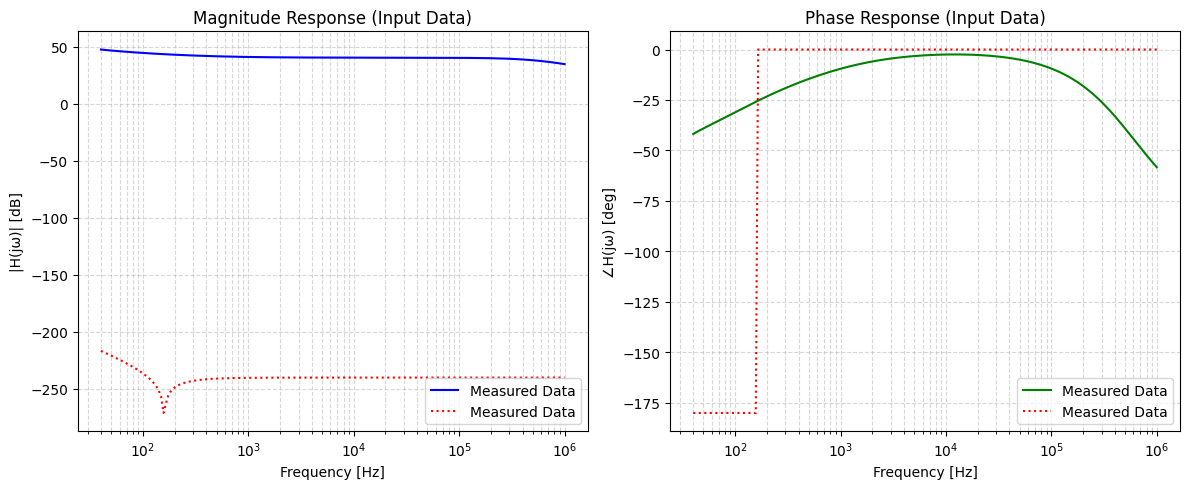

In [10]:
result_exp_W = minimize(
    loss_function,
    initial_guess,
    args=(freq, mag_exp['W.csv'], phase_exp['W.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_W)
optimized_params_exp_W = result_exp_W.x

mag_fit_exp_W, phase_fit_exp_W = coef2spectrum(optimized_params_exp_W,freq,order=order)
pltFit(freq, mag_exp['W.csv'], mag_fit_exp_W, phase_exp['W.csv'], phase_fit_exp_W)

**ICE**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 239
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0
             x: [ 1.000e+00  1.000e+01  1.000e+06  1.000e+00  0.000e+00
                  1.000e-06]
           nit: 30
          nfev: 239
 final_simplex: (array([[ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06],
                       ...,
                       [ 1.000e+00,  1.000e+01, ...,  4.657e-13,
                         1.000e-06],
                       [ 1.000e+00,  1.000e+01, ...,  0.000e+00,
                         1.000e-06]]), array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
                        0.000e+00,  0.000e+00,  0.000e+00]))


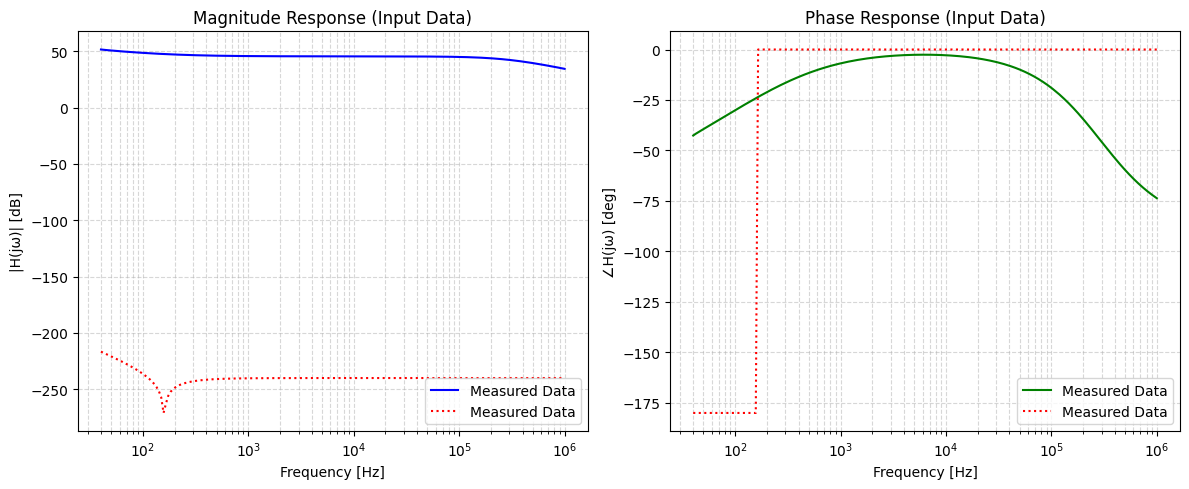

In [11]:
result_exp_ICE = minimize(
    loss_function,
    initial_guess,
    args=(freq, mag_exp['ICE.csv'], phase_exp['ICE.csv'], order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_ICE)
optimized_params_exp_ICE = result_exp_ICE.x

mag_fit_exp_ICE, phase_fit_exp_ICE = coef2spectrum(optimized_params_exp_ICE,freq,order=order)
pltFit(freq, mag_exp['ICE.csv'], mag_fit_exp_ICE, phase_exp['ICE.csv'], phase_fit_exp_ICE)

# **References**



1.   https://joss.theoj.org/papers/10.21105/joss.02349.pdf
2.   https://impedancepy.readthedocs.io/en/latest/getting-started.html

scipy.minimize
https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html#optimize-minimize-newtoncg